In [1]:
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.datasets import make_blobs, make_classification

os.makedirs("plots", exist_ok=True)

/home/pmangold/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import matplotlib as mpl

# Set global font properties and enable LaTeX rendering
mpl.rcParams.update({
    'font.size': 20,            # Set a uniform font size for all elements
    'text.usetex': True,        # Enable LaTeX-style text
    'font.family': 'serif',      # Use serif font similar to LaTeX's default
    'figure.facecolor': 'white',  # White background for the figure
    'axes.facecolor': 'white'
})

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def get_grad_batch(X, y, theta, lambda_, batch_size, rng):

    if batch_size < 0:
        return X.T @ (sigmoid(X @ theta) - y) / len(y) + lambda_ * theta    
    
    indices = np.arange(len(y))
    idx = rng.choice(indices, size=batch_size, replace=False)

    return X[idx].T @ (sigmoid(X[idx] @ theta) - y[idx]) / batch_size \
        + lambda_ * theta    


def gradient(X_, y_, theta, lambda_):
    return X_.T @ (sigmoid(X_ @ theta) - y_) / len(y_) + lambda_ * theta    

def compute_theta_star(data,lambda_,alpha=0.01,tol=1e-12):
    update = tol + 1
    theta = np.zeros(data[0][0].shape[1])
    last_update = np.inf
    n=0
    while update > tol:
        n=n+1
        grad = 0
        for (X, y) in data:
            grad += 1.0/len(data) * gradient(X, y, theta, lambda_)
        theta -= alpha * grad
        update = np.linalg.norm(grad)

        if last_update > update:
            alpha *= 1.01
        else:
            alpha /= 2

        last_update = update

    print("Theta star found in", str(n), "iterations.")
    return theta

In [4]:
def generate_dataset(n_samples=100, n_agents=10):

    rng=np.random.default_rng(seed=42)
    
    X, y = make_blobs(n_samples=n_samples, centers=([-2]*20,[0,4]*10),
                      n_features=20, cluster_std=10,
                      random_state=42)

    y[y>0]=1

    data_homogeneous = [(X,y) for _ in range(n_agents)]

    indices = np.array_split(np.arange(len(y)), n_agents)
    data_heterogeneous = [(X[idx], y[idx]) for idx in indices]

    return data_heterogeneous

In [5]:
def fed_avg(clients_data,
            theta, step, lambda_, batch_size, 
            n_local, n_rounds,
            seed=None):
    
    rng = np.random.default_rng(seed)

    theta = theta.copy()
    loc_theta = np.array([theta.copy() for _ in range(len(clients_data))])

    hist = [theta.copy()]

    for t in tqdm(range(n_rounds)):

        for c in range(len(clients_data)):
            loc_theta[c] = theta.copy()

            for h in range(n_local):
                grad = get_grad_batch(clients_data[c][0], clients_data[c][1],
                                      loc_theta[c], lambda_, batch_size, rng)
                loc_theta[c] = loc_theta[c] - step * grad


        theta = np.mean(loc_theta, axis=0)
        hist.append(theta.copy())

    return np.array(hist)



In [6]:
def scaffold(clients_data,
             theta, step, lambda_, batch_size, 
             n_local, n_rounds,
             seed=None):
    
    rng = np.random.default_rng(seed)
        
    theta = theta.copy()
    loc_theta = np.array([theta.copy() for _ in range(len(clients_data))])
    xi = np.array([np.zeros(theta.shape) for _ in range(len(clients_data))])

    hist = [theta.copy()]
            
    for t in tqdm(range(n_rounds)):

        for c in range(len(clients_data)):

            loc_theta[c] = theta.copy()

            for h in range(n_local):
                grad = get_grad_batch(clients_data[c][0], clients_data[c][1],
                                      loc_theta[c], lambda_, batch_size, rng)

                loc_theta[c] = loc_theta[c] - step * ( grad - xi[c] )

        theta = np.mean(loc_theta, axis=0)
        xi += 1 / (step * n_local) * (theta - loc_theta) 
        hist.append(theta.copy())

    return np.array(hist)



In [7]:
data = generate_dataset()
lambda_ = 0.001
step = 0.01
Hs = [1, 10, 30, 100, 1000]
batch_sizes = [1, -1]
max_T = 10000

In [8]:
theta_star = compute_theta_star(data, lambda_=lambda_)

Theta star found in 366 iterations.


In [9]:
scafit1, scafit2, fedavg1, fedavg2 = {}, {}, {}, {}

In [10]:
theta0 = theta_star + step * np.ones(len(theta_star))
theta1 = theta_star + 2*step * np.ones(len(theta_star))

In [ ]:
for step in [0.01, 0.001]:

    for batch_size in batch_sizes:
        for H in Hs:
            T = int(max_T/H)

            scafit1[(H,batch_size)] = scaffold(data, theta0, step, lambda_, batch_size, H, T, seed=1)
            scafit2[(H,batch_size)] = scaffold(data, theta1, step, lambda_, batch_size, H, T, seed=1)
            fedavg1[(H,batch_size)] = fed_avg(data, theta0, step, lambda_, batch_size, H, T, seed=1)
            fedavg2[(H,batch_size)] = fed_avg(data, theta1, step, lambda_, batch_size, H, T, seed=1)

    fig, ax = plt.subplots(len(batch_sizes), len(Hs), figsize=(20,8))
    for x, batch_size in enumerate(batch_sizes):
        for y, H in enumerate(Hs):
            ax[x][y].plot(np.linalg.norm(scafit1[(H,batch_size)] - scafit2[(H,batch_size)], axis=1)**2, label="Scaffold")
            ax[x][y].plot(np.linalg.norm(fedavg1[(H,batch_size)] - fedavg2[(H,batch_size)], axis=1)**2, label="FedAvg")
            ax[x][y].set_yscale("log")

            ax[x][y].set_xlabel("Communications")
            ax[x][y].set_ylabel("$\\| \\theta_t - \\theta'_t \\|^2$")
            ax[x][y].set_title("$\gamma$="+str(step)+", H=" + str(H) + ", batch=" + {1: "1", -1: "full"}[batch_size])
    ax[-1][-1].legend()
    plt.suptitle("Distance between iterates with same seed but different initialization "
                        "with $\\theta_0 = (0,...,0)$ and $\\theta'_0 = (1,...,1)$")
    plt.tight_layout()
    plt.savefig("plots/contraction-scaffold-fedavg_all_step" + str(step) + ".png", bbox_inches="tight")

 47%|███████████████████████████████████████████████▉                                                      | 47/100 [00:01<00:01, 28.72it/s]

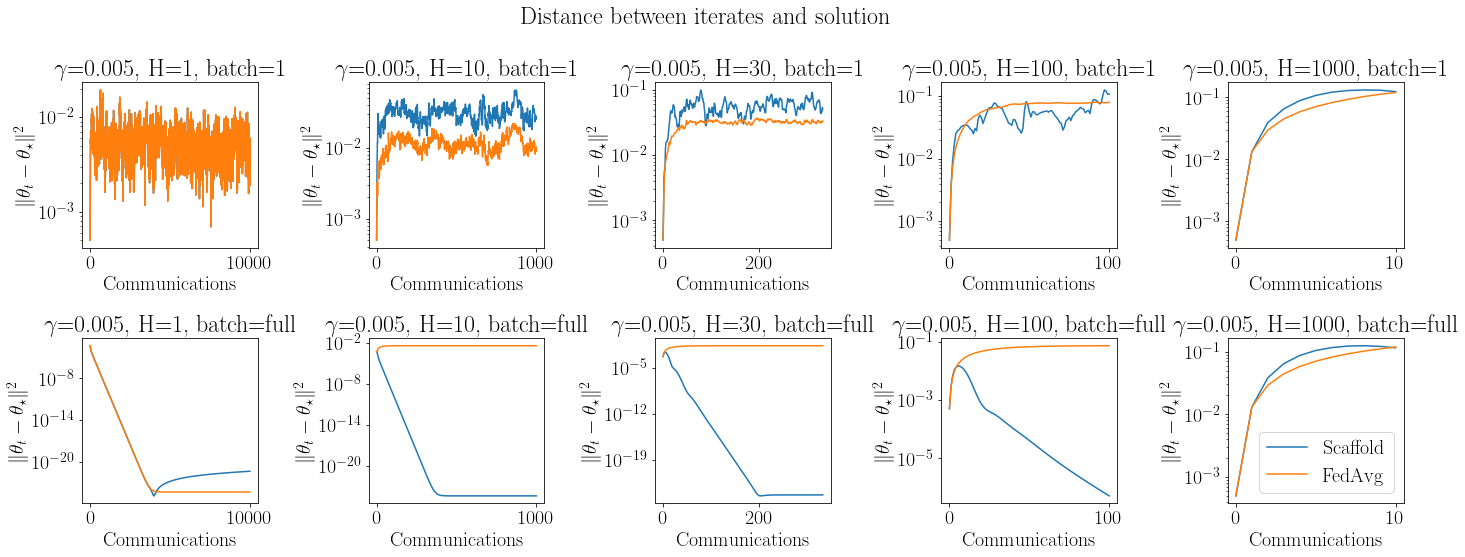

In [332]:
fig, ax = plt.subplots(len(batch_sizes), len(Hs), figsize=(20,8))
for x, batch_size in enumerate(batch_sizes):
    for y, H in enumerate(Hs):
        ax[x][y].plot(np.linalg.norm(scafit1[(H,batch_size)] - theta_star, axis=1)**2, label="Scaffold")
        ax[x][y].plot(np.linalg.norm(fedavg1[(H,batch_size)] - theta_star, axis=1)**2, label="FedAvg")
        ax[x][y].set_yscale("log")

        ax[x][y].set_xlabel("Communications")
        ax[x][y].set_ylabel("$\\| \\theta_t - \\theta_\\star \\|^2$")
        ax[x][y].set_title("$\gamma$="+str(step)+", H=" + str(H) + ", batch=" + {1: "1", -1: "full"}[batch_size])
ax[-1][-1].legend()
plt.suptitle("Distance between iterates and solution")
plt.tight_layout()
plt.savefig("plots/contraction-scaffold-fedavg_all.png", bbox_inches="tight")

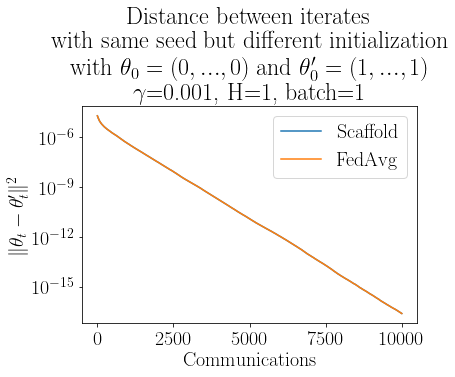

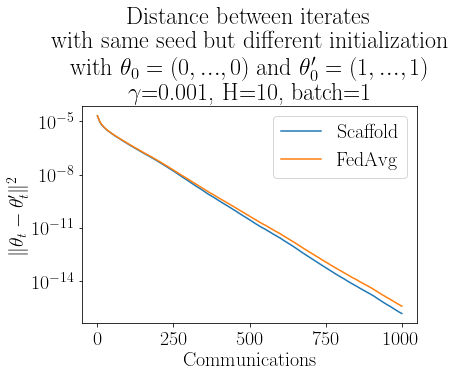

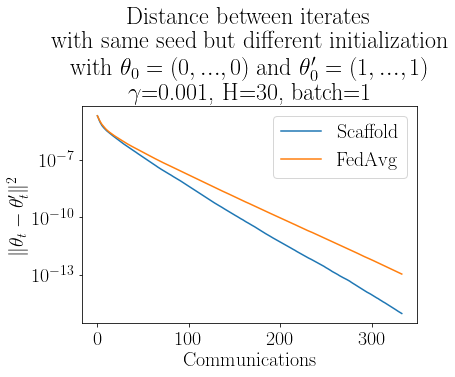

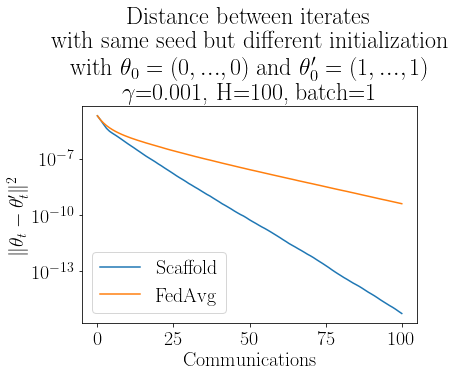

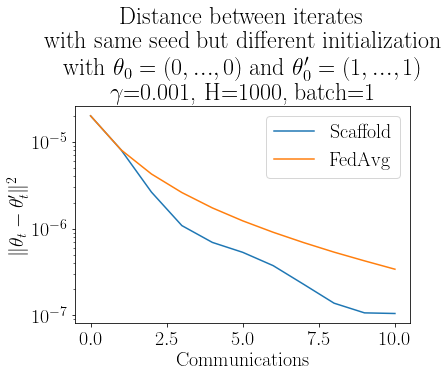

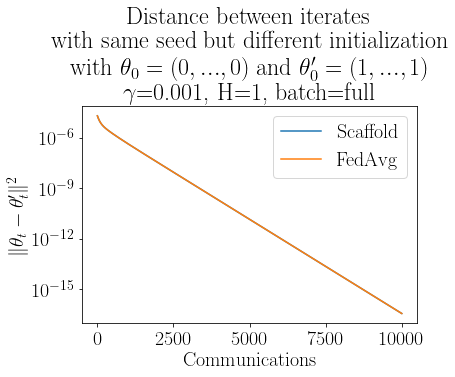

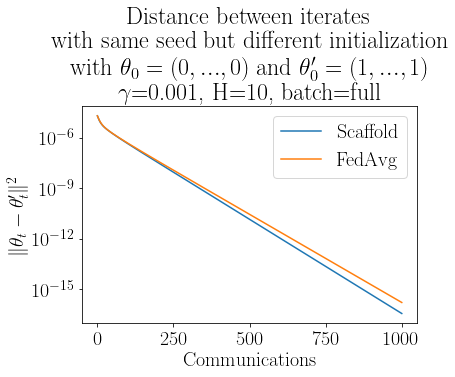

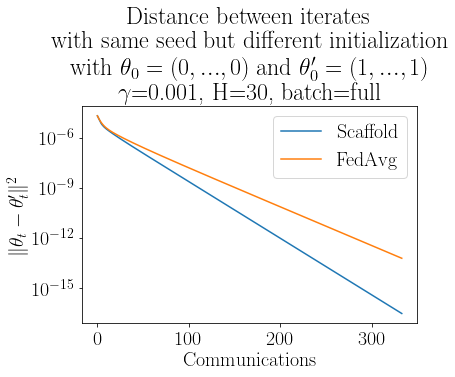

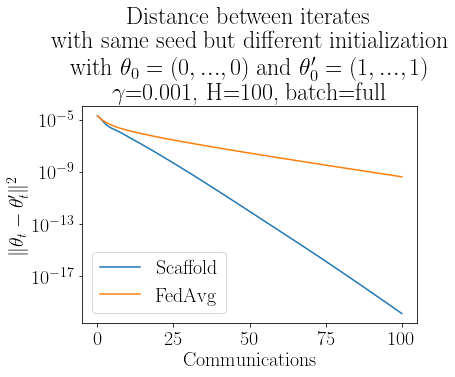

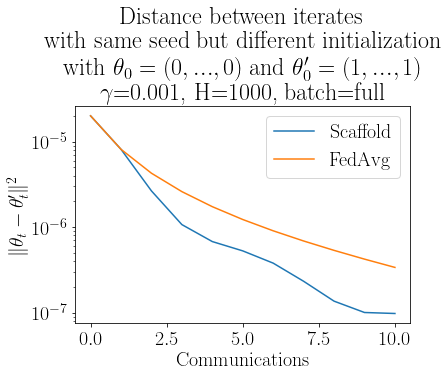

In [323]:
for batch_size in batch_sizes:
    for H in Hs:
        plt.subplots()
        plt.plot(np.linalg.norm(scafit1[(H,batch_size)] - scafit2[(H,batch_size)], axis=1)**2, label="Scaffold")
        plt.plot(np.linalg.norm(fedavg1[(H,batch_size)] - fedavg2[(H,batch_size)], axis=1)**2, label="FedAvg")
        plt.yscale("log")

        plt.xlabel("Communications")
        plt.ylabel("$\\| \\theta_t - \\theta'_t \\|^2$")
        plt.legend()
        plt.title("Distance between iterates \n with same seed but different initialization\n"
                    "with $\\theta_0 = (0,...,0)$ and $\\theta'_0 = (1,...,1)$\n"
                    "$\gamma$="+str(step)+", H=" + str(H) + ", batch=" + {1: "1", -1: "full"}[batch_size])
        plt.savefig("plots/contraction-scaffold-fedavg_"+str(H)+".png", bbox_inches="tight")